In [16]:
# emotion_utils.py

import numpy as np
import librosa
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
import pickle

def extract_features(data, sample_rate = 16000):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result


def predict_emotion(model, audio_file, scaler, segment_duration=5, overlap=2):
    # Load the entire audio file
    waveform, sample_rate = librosa.load(audio_file, sr=None)

    # Segment the audio file
    segments = []
    predictions = []

    for start in range(0, len(waveform), int((segment_duration - overlap) * sample_rate)):
        end = min(start + segment_duration * sample_rate, len(waveform))
        segment = waveform[start:end]
        segments.append(segment)

    # Predict emotions for each segment
    for segment in segments:
        features = extract_features(segment)
        scaled_features = scaler.transform(features.reshape(1, -1))
        scaled_features = np.expand_dims(scaled_features, axis=2)
        prediction = model.predict(scaled_features)
        predictions.append(prediction.flatten())

    return np.array(predictions)

def plot_emotion_evolution(time_intervals, all_predictions, emotions, save_path):
    # Plot the emotions over time as dots with connecting lines
    plt.figure(figsize=(12, 6))
    for i, emotion in enumerate(emotions):
        plt.scatter(time_intervals, all_predictions[:, i], label=emotion, s=50)
        plt.plot(time_intervals, all_predictions[:, i], alpha=0.3, linewidth=0.5, color='gray')

    plt.title('Emotion Evolution Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Confidence')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.savefig(save_path, bbox_inches='tight')

    plt.show()


1/1 [==============================] - 0s 46ms/step


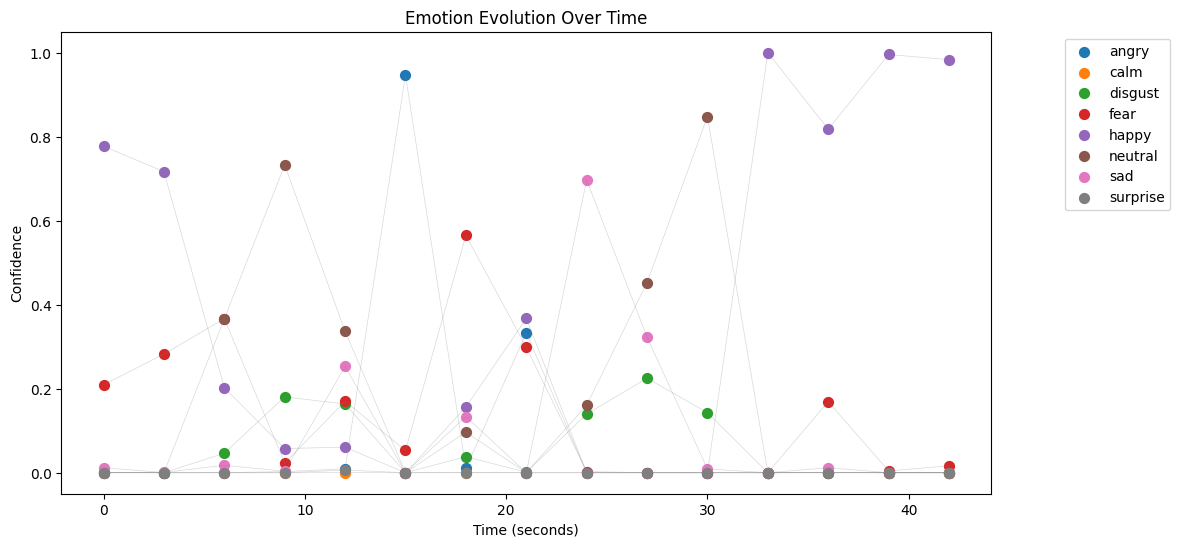

In [19]:
# main_script.py

#from emotion_utils import predict_emotion, plot_emotion_evolution

# Example usage
model = load_model('/kaggle/input/model-ser/ser_model.h5')
audio_file = '/kaggle/input/long-recording/1001-iom-sad-xx_HGQQz0Fy (Joined by Happy Scribe).wav'
with open('/kaggle/input/scaler/fitted_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
segment_duration = 5
overlap = 2

# To predict emotions
predictions = predict_emotion(model, audio_file, scaler)

time_intervals = np.arange(0, len(predictions) * (segment_duration - overlap), segment_duration - overlap)
emotions = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# To save the plot as an image
plot_emotion_evolution(time_intervals, predictions, emotions, save_path='emotion_evolution_plot.png')
